# FACE RECOGNITION WITH HOG FEATURES AND DEEP LEARNING

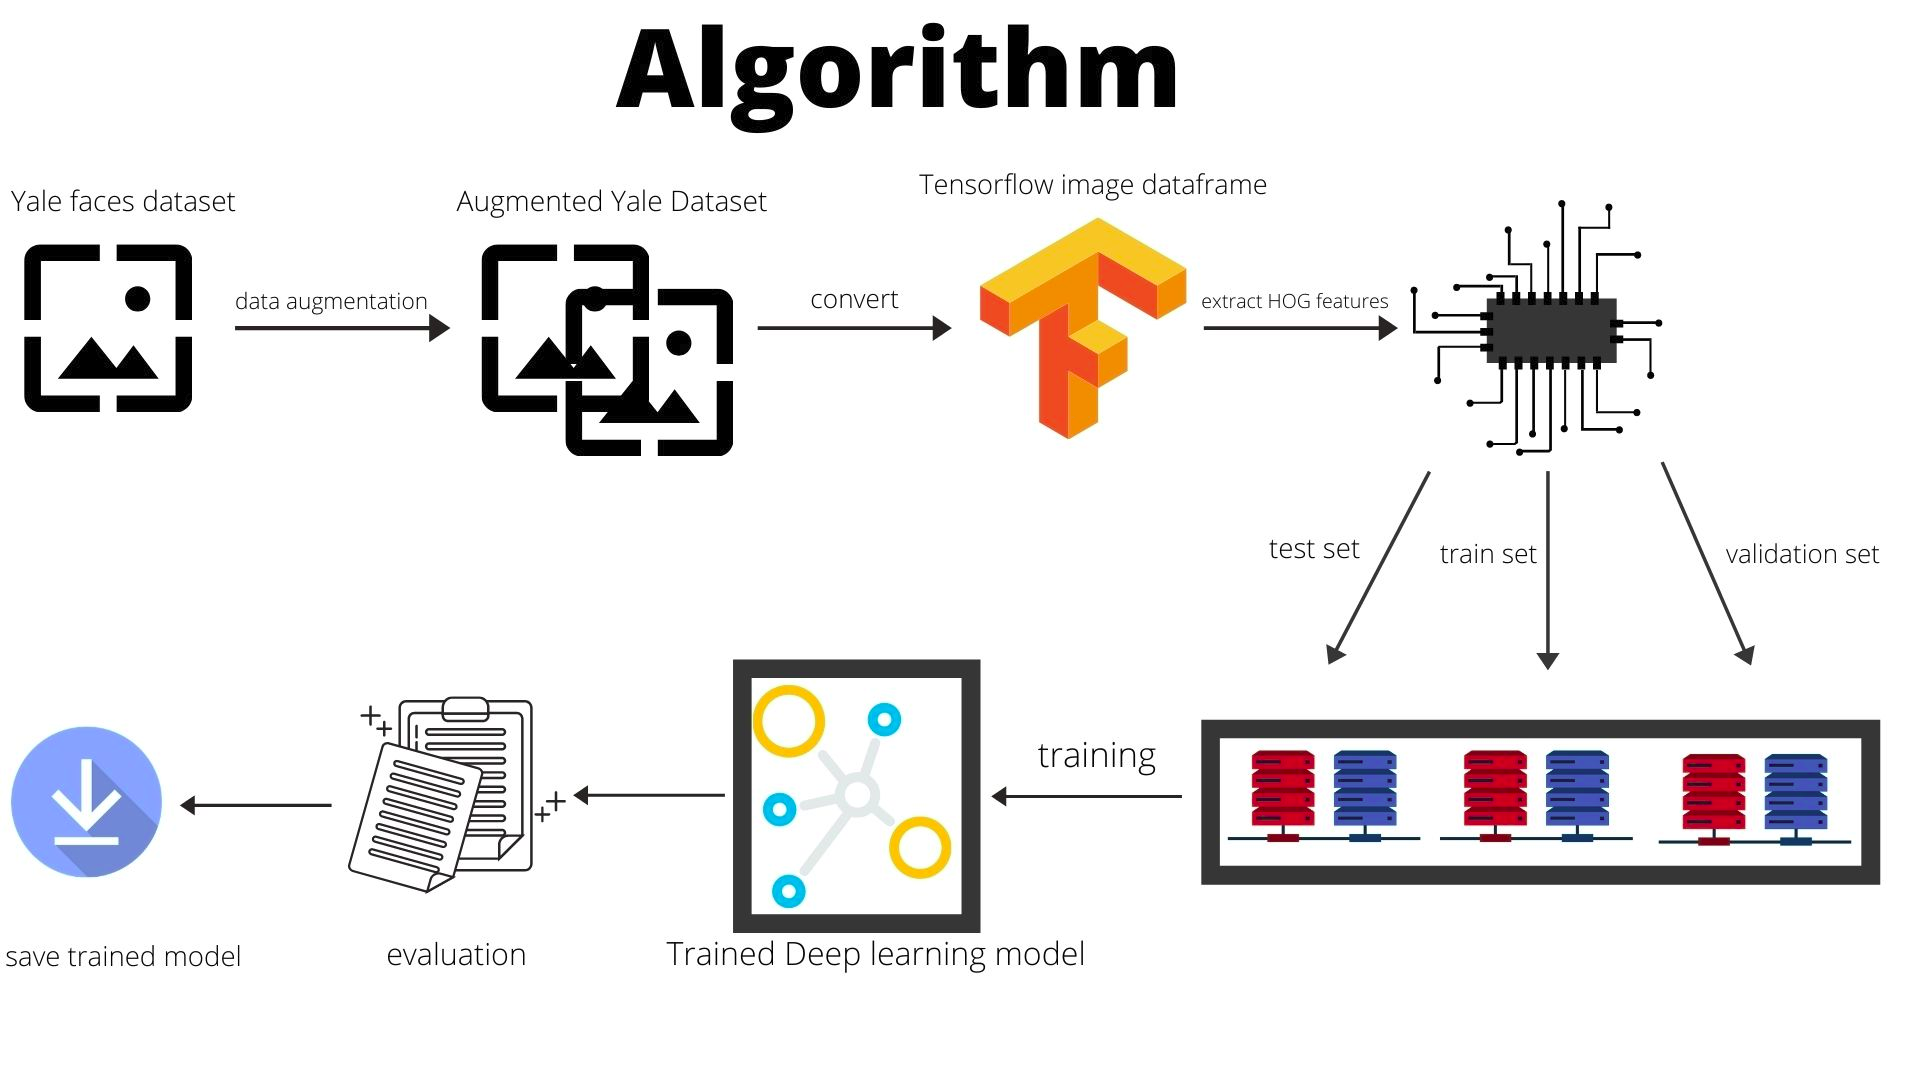

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage import color
from skimage.feature import hog
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD

## Mounting the augmented Yale faces Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
directory = '/content/drive/MyDrive/yalefaces'

data_set =tf.keras.preprocessing.image_dataset_from_directory(
    directory, labels='inferred', label_mode='int',
    class_names=['subject_1', 'subject_10', 'subject_11', 'subject_12', 'subject_13', 'subject_14', 'subject_15', 'subject_2', 'subject_3', 'subject_4', 'subject_5', 'subject_6', 'subject_7', 'subject_8', 'subject_9'],
    color_mode='grayscale', batch_size=1, image_size=(128, 128), shuffle=True, seed=None, validation_split=None, subset=None,
)

Found 1500 files belonging to 15 classes.


In [ ]:
lst = list(data_set)

In [ ]:
data, label = map(np.array,zip(*lst))

In [ ]:
data = data.astype('uint8').reshape(1500,128,128)

In [ ]:
label = tf.keras.utils.to_categorical(label, num_classes=15)

## Extracting HOG features from image dataset

In [ ]:
hog_images = []
hog_features = []
for image in data:
    fd,hog_image = hog(image, orientations=8, pixels_per_cell=(4,4),cells_per_block=(3, 3),block_norm= 'L2',visualize=True)
    hog_images.append(hog_image)
    hog_features.append(fd)

In [ ]:
hog_features = np.array(hog_features)

## Test-Train Split(80:20)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(hog_features, label, stratify=label, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [ ]:
X_train.shape

(960, 64800)

## Model Architecture
input layer shape = 64800

number of hidden layers = 4

output layer shape = 15(categorical one-hot encoding)

number of weights = 6,70,45,248

In [ ]:
inputs = layers.Input(shape=(64800))
x = layers.Dense(1024, activation="relu")(inputs)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x) 
x = layers.Dense(128, activation="relu")(x)
outputs = layers.Dense(15, activation="softmax")(x) 

model = Model(inputs=inputs, outputs=outputs, name="Unisys_Model")

## Training

number of epochs = 34

In [ ]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

history = model.fit(x=X_train, y=y_train, epochs=34, batch_size=1, validation_data=(X_val, y_val))

Epoch 1/34
960/960 [==============================] - 18s 15ms/step - loss: 1.7802 - accuracy: 0.4646 - val_loss: 0.5633 - val_accuracy: 0.8083
Epoch 2/34
960/960 [==============================] - 14s 15ms/step - loss: 0.6254 - accuracy: 0.8323 - val_loss: 1.7411 - val_accuracy: 0.6750
Epoch 3/34
960/960 [==============================] - 14s 15ms/step - loss: 0.2778 - accuracy: 0.9417 - val_loss: 0.7021 - val_accuracy: 0.8125
Epoch 4/34
960/960 [==============================] - 14s 15ms/step - loss: 0.3887 - accuracy: 0.9250 - val_loss: 0.3426 - val_accuracy: 0.9292
Epoch 5/34
960/960 [==============================] - 14s 15ms/step - loss: 0.4037 - accuracy: 0.9281 - val_loss: 0.2394 - val_accuracy: 0.9458
Epoch 6/34
960/960 [==============================] - 14s 15ms/step - loss: 0.1783 - accuracy: 0.9729 - val_loss: 0.0750 - val_accuracy: 0.9750
Epoch 7/34
960/960 [==============================] - 14s 15ms/step - loss: 0.0305 - accuracy: 0.9937 - val_loss: 0.0930 - val_accuracy:

## Evaluating on the test set

In [ ]:
model.evaluate(X_test, y_test)

10/10 [==============================] - 0s 7ms/step - loss: 0.0707 - accuracy: 0.9900


[0.0706683024764061, 0.9900000095367432]

## Analysing Model performance

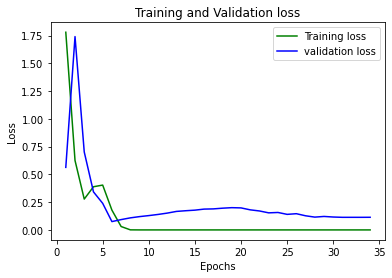

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,35)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

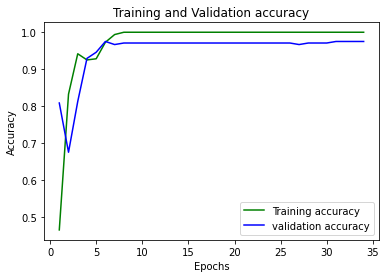

In [ ]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,35)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpdvl1pzbf/assets


In [ ]:
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)